# ST446 Distributed Computing for Big Data
## Seminar class 7: Scalable machine learning I

In this notebook we provide a simple implementation of batch gradient descent for logistic regression.  This implementation is not what you would use in practice, but it helps to understand the underlying concepts.

We also demonstrate how the number of iterations affects the training error.

We start by using the sample data set `sample_svm_data.txt`. 

Reference: https://github.com/apache/spark/blob/master/examples/src/main/python/logistic_regression.py

### Strategy
Recall that to train the logistic regression model, we will need the gradient of the losss function with respect to the weights $\vec{w}$. The gradient will have entries 
$$\frac{\partial}{\partial w_i} f(\vec{w},\text{data}),$$ 
where the loss function $f$ for given data is the negative log-likelihood $f(\vec{w},\text{data}) = -\ell(\vec{w})$. Our data consists of features $\vec{x}_i$ and labels $y_i$ with $i = 1,\dots, m$.

For logistic regression, we know from the lecture that the log-likelihood is
$$
\ell(\vec{w}) = \frac{1}{m}\sum_{i=1}^m \left[y_i \vec{x}_i \cdot \vec{w} - \log\left(1+e^{\vec{x}_i \cdot \vec{w}}\right)\right].
$$
Hence, our job is to implement the gradient (here written as a row vector)
$$
\nabla \ell(\vec{w}) = \frac{1}{m} \sum_i \left(y_i \vec{x}_i - \frac{e^{\vec{x}_i \cdot \vec{w}}}{1+e^{\vec{x}_i \cdot \vec{w}}} \vec{x}_i\right) \\ = \sum_i \frac{1}{m} \vec{x}_i \left( y_i - \frac{1}{1+e^{-\vec{x}_i \cdot \vec{w}}}\right)
$$
such that we can perform steps towards the minimum of the loss function
$$
\vec{w}_{t+1} = \vec{w}_t -  \eta_t\nabla f(\vec{w}_t,\text{data}) \\
= \vec{w}_t + \frac{\eta_t}{m}  \left[  \sum_i \vec{x}_i \left( y_i - \frac{1}{1+e^{-\vec{x}_i \cdot \vec{w}}}\right) \right] 
$$
As we can see below, we will store the data in numpy matrices, such that this gradient can be computed  entirely with numpy functions.

Instead of computing this sum for all indices $i$ at once, we can split the training data into, say, 5 batches $B_j$ of size $n = m/5$. Also, we will convert everything to row vectors.
This means, we will get
$$
\vec{w}_{t+1}^\top = \vec{w}_t^\top - \frac{\eta_t}{5}  \sum_{j=1}^5\left\{ \frac{1}{n} \sum_{i\in B_j} \vec{x}^\top_i \left( y_i - \frac{1}{1+e^{-\vec{x}_i \cdot \vec{w}}}\right) \right\} \quad (\star)
$$
Note that we really did nothing here!

Now, the term in $\{\}$ can be computed by separate workers on separate partitions of an RDD.
This is a map step.

Then, we can perform the outer sum as reduce step, which requires workers to talk to the master.

Next, we update the weight vector $\vec{w}_{t} \to \vec{w}_{t+1} = \vec{w}_{t} +\eta_t (\dots)$. Because the weight vector is small (here is has length 16), we can easily do this on the master node.

Please sure you understand where the different parts of $(\star)$ show up in the code below!

In [1]:
# change to where Spark lives on your machine/compute engine (usually $SPARK_HOME)
spark_home = "file:///usr/lib/spark"

### Implementation

The key idea is that we will load the data into an RDD and use the RDD's partitioning as our batches.
We then use `mapPartitions` to apply a partition-wise function to format the data as a numpy array in the right shape. This will allow us to call optimised (i.e. fast) numpy functions for each partition.

![GD](./fig/distributedGD.png)

In [3]:
# import necessary libraries
import sys
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# input
D = 16             # Number of dimensions (size of weight vector)
iterations = 200   # Number of iterations

# Read a batch of points from the input file into a NumPy matrix object. We operate on batches to
# make further computations faster.
# The data file contains lines of the form <label> <x1> <x2> ... <xD>. We load each block of these
# into a NumPy array of size numLines * (D + 1) and pull out column 0 vs the others in gradient().
def readPointBatch(iterator):
    strs = list(iterator)
    matrix = np.zeros((len(strs), D + 1))
    for i, s in enumerate(strs):
        matrix[i] = np.fromstring(s, dtype=np.float32, sep=' ')
    return [matrix]

# dataset to be used
# here we will be using the partitions as batches.
points = spark.read.text(spark_home+"/data/mllib/sample_svm_data.txt").rdd.repartition(5)

# number of data points
n = points.count() 

# see explanation in the next cell
points = points.map(lambda r: r[0])\
    .mapPartitions(readPointBatch).cache() 

`mapPartition` operates on individual partitions of the RDD, that is, the `for` loop inside `readPointBatch` will iterate though the elements of each partition.
Here, caching the data prevents future re-loading of the data upon each lazy evaluation. This is important, as we will later use it in each iteration of the gradient descent.

Initial w: [ 0.80447849  0.58412445  0.88865674 -0.57983304 -0.13572482  0.1102371
  0.97465562 -0.9534808  -0.69847927 -0.63210783  0.39723133 -0.34048155
 -0.40044425  0.27824074  0.18882086 -0.73738064]
*** On iteration 50 ***
Gradient descent:  [ 0.40984691  0.30165578  0.39996973 -0.38815515 -0.00945966  0.03082005
  0.35824087 -0.29805962 -0.21545777 -0.21545777  0.0241376  -0.07573616
 -0.32667583  0.06440437 -0.03940016 -0.29728247]
Current w:  [ 0.24396379  0.21258616  0.30056597 -0.08571358 -0.23439455 -0.06501694
  0.38614501 -0.69331102 -0.12742544 -0.061054    0.4295895  -0.34451543
 -0.02610691  0.19775516  0.23076987 -0.4380877 ]
Total error: 0.4409937888198758
*** On iteration 100 ***
Gradient descent:  [ 0.15704631  0.09376574  0.11783044 -0.15949301 -0.03229026 -0.02056571
  0.08312746 -0.13214796 -0.02908986 -0.02908986  0.03388195 -0.06624602
 -0.09886752  0.11665199  0.09070388 -0.10750354]
Current w:  [-0.0188042   0.02890333  0.0654804   0.17865693 -0.20304101 -0

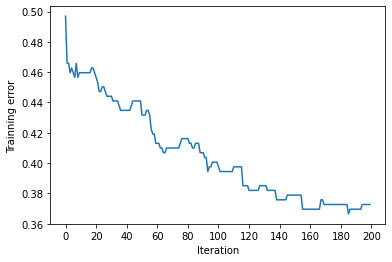

In [5]:
# Initialize w to a random values in [-1,1].
w = 2 * np.random.ranf(size=D) - 1
print("Initial w: " + str(w))

# Compute logistic regression gradient for a matrix of data points
def gradient(matrix, w):
    Y = matrix[:, 0]    # point labels (first column of input file)
    X = matrix[:, 1:]   # point coordinates
    
    # For each point (x, y), compute gradient function 
    # (see the lecture note "gradient descent for logistic regression")
    # and take the average of it
    # note the minus sign is needed because minimizing the loss function is equal to 
    # minimizing the negative log likelihood
    return -(X.T * (Y - 1.0/(1.0+np.exp(-X.dot(w))))).sum(1) / len(Y)

def add(x, y):
    x += y
    return x

# calculate classification error
def pred_err(matrix, w):
    Y = matrix[:, 0]
    X = matrix[:, 1:]
    # this is the number of miss-classified examples.
    err = sum(Y!=(1.0/(1.0+np.exp(-X.dot(w)))>0.5))  
    return (err)

# train the model using gradient descent with step size eta
eta = 0.1
err = np.zeros(iterations)

for i in range(iterations):
    g = points.map(lambda m: gradient(m, w)) # compute batch gradient at point w
    num_batch = g.getNumPartitions()
    g = g.reduce(add)                        # compute sum of batch gradients 
    # use eta as the step size
    w -= eta/num_batch * g                   # convert sum to average gradient and perform gradient descent step 
    err[i] = points.map(lambda m: pred_err(m, w)).reduce(add)/float(n)
    
    if (i + 1) % 50 == 0 and i+1 != iterations:
        print("*** On iteration %i ***" % (i + 1))
        print("Gradient descent: ", str(g))
        print("Current w: ", str(w))
        print("Total error:", err[i])

print("*** Final w: " + str(w) + "***")

# plot the training error over time
plt.plot(err)
plt.xlabel("Iteration")
plt.ylabel("Trainning error")
plt.xticks(np.arange(0, iterations+1, 20));

### Further discussions and activities

#### Termination criterion

In the optimisation above, we fix the number of iterations of gradient descent in advance. However, choosing the right number of iterations is tricky: fewer iterations leads to underfitting and more iterations will take more time.
Instead, people use termination criterion to stop the optimisation.
We will specify a precision parameter $\epsilon > 0$ and run $T(\epsilon)$ rounds:

$$
T(\epsilon) = \min \{t\geq 1: ||\vec{w}_{t} - \vec{w}_{t-1}||_\infty \leq \epsilon\}
$$

Can you plot $T(\epsilon)$ as a function of $\epsilon$? 

(hint: log-log plot)


#### Computation speedup from data parallelism

Dividing the data into batches and run the computation on batches in parallel is called [data parallelism](https://en.wikipedia.org/wiki/Data_parallelism).
Choosing the right number of batches can be also tricky: more batches lead to smaller matrix size in each batches and as a result we might lose the speedup from the highly optimised linear algebra library, e.g. `numpy`

Can you plot the computation time as a function of the number of batches?

#### Real applications: Criteo CTR prediction challenge

In the lecture, we introduced the [Criteo Ads click dataset](https://labs.criteo.com/2013/12/download-terabyte-click-logs/). 

Can you train a logistic regression model to predict the CTR using the Day 0 data from Criteo?